# Dubai Real Estate Price Prediction Code
## Rental Properties Dataset Model

- Kiana Johnson & Thomas Myers (Group 2B)
- CDS-492, Dr. Slamani

## Modeling

In order to best analyze which features are the best predictors of Rent, modeling must be performed. Using a random forest regressor model, the R-Squared values of the features can be predicted. 

In [1]:
# importing necessary packages for modeling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score, classification_report, accuracy_score

from sklearn.preprocessing import StandardScaler

In [2]:
# loading in cleaned dataset after outlier-removal
df_CM = pd.read_csv('out_properties.csv') # dubai rental properties

In [6]:
# creating dummy columns for the property type feature
df_encoded = pd.get_dummies(df_CM, columns=['type'], drop_first=True)

# dropping unnecessary columns (to help model run efficiently and reduce processing time)
df_encoded = df_encoded.drop(columns=['furnishing', 'purpose', 'location', 'rent_category'])

# defining the input and output features
X = df_encoded.drop('rent', axis=1)
y = df_encoded['rent']

# normalizing the features because the dataset is imbalanced
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)

# implementing the hyperparameters that the were the best the grid search. (more hyperparameters were tested originally)
# to avoid long processing time, these were used for small adjustment
best_params = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt'
}

# initializing and training the model with the best hyperparameters
best_rf_model = RandomForestRegressor(**best_params)
best_rf_model.fit(X_train, y_train)

# predicting on the training and test sets
y_train_pred_scaled = best_rf_model.predict(X_train)
y_test_pred_scaled = best_rf_model.predict(X_test)

# transforming predictions back to the original scale, making the interpretation of results better
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# calculate evaluation metrics for training and test sets (R2, MSE and RMSE)
mse_train = mean_squared_error(y_train_original, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train_original, y_train_pred)
mse_test = mean_squared_error(y_test_original, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred)

# displays hyperparameters used in the model
print(f"Best Hyperparameters: {best_params}")
print(f"Training Mean Squared Error: {mse_train}")
print(f"Training Root Mean Squared Error: {rmse_train}")
print(f"Training R^2 Score: {r2_train}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test Root Mean Squared Error: {rmse_test}")
print(f"Test R^2 Score: {r2_test}")

Best Hyperparameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
Training Mean Squared Error: 182265200.00710088
Training Root Mean Squared Error: 13500.56295148839
Training R^2 Score: 0.6574708140430567
Test Mean Squared Error: 202237613.01122522
Test Root Mean Squared Error: 14221.027143326364
Test R^2 Score: 0.6046575294130494


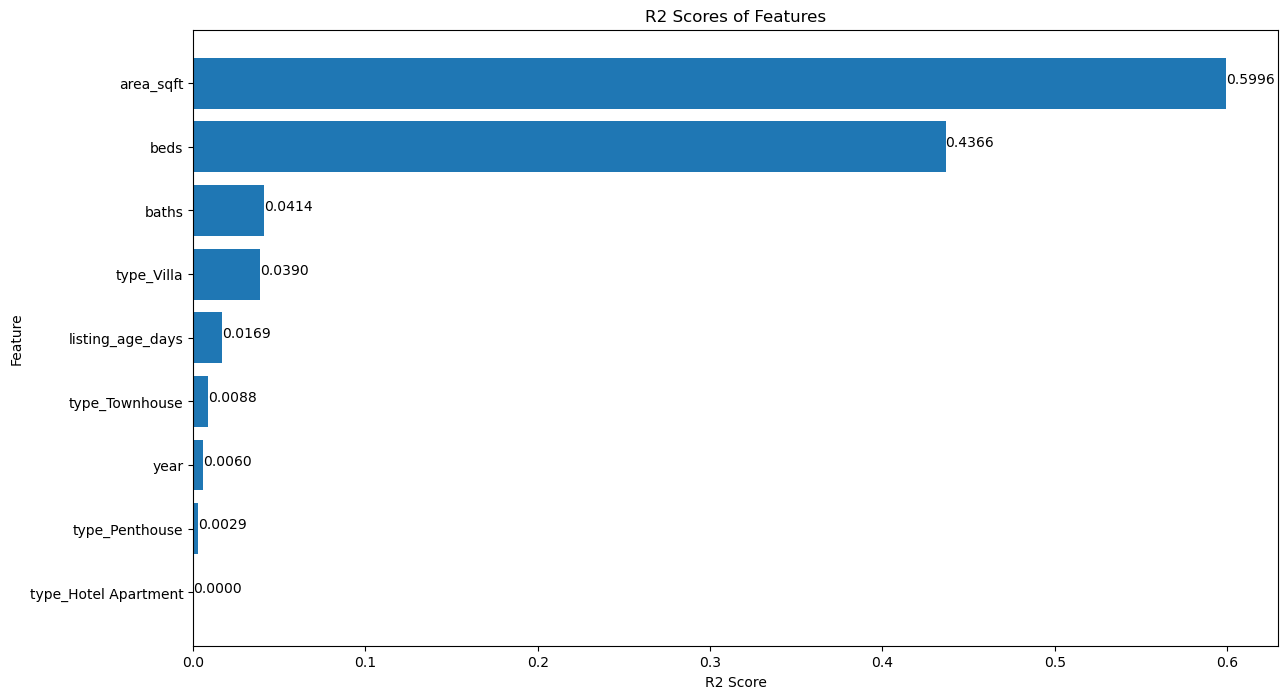

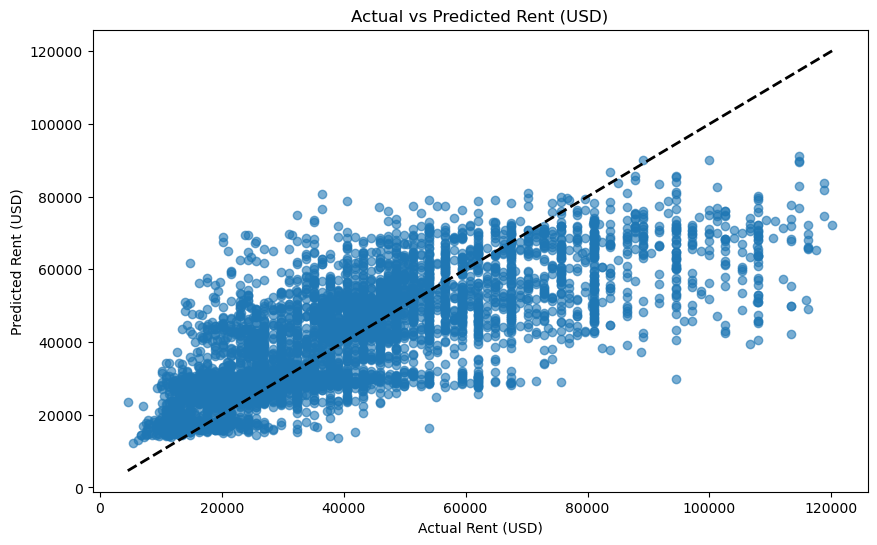

In [7]:
# creating separate table with all the R2 feature scores
r2_scores = []
features = X.columns
for feature in features:
    X_feature = X[[feature]]
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_feature, y, test_size=0.2)
    rf_model_f = RandomForestRegressor(**best_params)
    rf_model_f.fit(X_train_f, y_train_f)
    y_pred_f = rf_model_f.predict(X_test_f)
    r2_f = r2_score(y_test_f, y_pred_f)
    r2_scores.append(r2_f)
    
# the values are calculated by looking at the difference in the overall R2 scores when the feature is removed to when it is in the model.
r2_df = pd.DataFrame({'Feature': features, 'R2 Score': r2_scores})

# filtering out features with negative R2 scores
r2_df = r2_df[r2_df['R2 Score'] > 0]
r2_df = r2_df.sort_values(by='R2 Score', ascending=False)

# plotting R2 scores with values
plt.figure(figsize=(14, 8))
plt.barh(r2_df['Feature'], r2_df['R2 Score'])
plt.xlabel('R2 Score')
plt.ylabel('Feature')
plt.title('R2 Scores of Features')
plt.gca().invert_yaxis()

# labels the bars in the graph with their R2 value
for index, value in enumerate(r2_df['R2 Score']):
    plt.text(value, index, f'{value:.4f}')
plt.show()

# scatter plot for actual vs predicted annual rent, allows us to look at the overall trend of the data
# also, how the line of best fit matches the model.
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_test_pred, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.xlabel('Actual Rent (USD)')
plt.ylabel('Predicted Rent (USD)')
plt.title('Actual vs Predicted Rent (USD)')
plt.show()

### Modeling - Snapshot:

- #### Model Results
    - The model results in a decent R-Squared value. The Test result is around 0.6 and the training result is around 0.65.
- #### R-Squared Bar chart:
    - The Bar chart shows the R-Squared values of the features in the model. 
    - Area, the number of beds, and property type have the highest R-Squared values and are the best predictors of rent in this dataset.
   
- #### Scatterplot: 
    -  The scatterplot compares the actual rent to the predicted rent. The predictions appear to get worse as the the actual rent increases.
    


In [1]:
'''
# this is how the full grid search code would be integrated into the code: 

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)

#This sets up the gridsearch and the parameters it is searching for
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# executing the the grid search to determine the best parameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='R2', verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

# predicting on the training and test sets
y_train_pred_scaled = best_rf_model.predict(X_train)
y_test_pred_scaled = best_rf_model.predict(X_test)
'''

"\n# this is how the full grid search code would be integrated into the code: \n\n# splitting the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)\n\n#This sets up the gridsearch and the parameters it is searching for\nparam_grid = {\n    'n_estimators': [50, 100, 200],\n    'max_depth': [None, 10, 20, 30],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'max_features': ['sqrt', 'log2']\n}\n\n# executing the the grid search to determine the best parameters\ngrid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='R2', verbose=2)\ngrid_search.fit(X_train, y_train)\nbest_rf_model = grid_search.best_estimator_\n\n# predicting on the training and test sets\ny_train_pred_scaled = best_rf_model.predict(X_train)\ny_test_pred_scaled = best_rf_model.predict(X_test)\n"